# Model Selection 

The objective of this notebook is to build a very first ent to end Machine Learning model to predict the probability of a patient being discharged on a particular day.

We'll use the dataset generated by the `dataset` job of the ETL folder. 

At this instance, the focus won't be on model performance but rather on understanding the value potential of the available data and the speedness of the solution.

In [2]:
%cd /Users/josefinadallavia/Documents/MIM/Tesis/AML-hospital

/Users/josefinadallavia/Documents/MIM/Tesis/AML-hospital


In [3]:
import os
import pandas as pd
from matplotlib import pyplot as plt   
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from thesis_lib.utils import * 
from thesis_lib.modelling.data import *
from thesis_lib.modelling.model import *
import warnings
warnings.filterwarnings('ignore')

/Users/josefinadallavia/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/josefinadallavia/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/josefinadallavia/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [4]:
data = Data().load('data/hospital_dataset')
variables = data.get_variables_dict()
data.get_stats()

Loading dataset:  hospital_train_data.parquet
Loading dataset:  hospital_val_data.parquet
Loading dataset:  hospital_test_data.parquet


dataset_type,train,val,test
n_observations,319150,33482,33309
relative_size,0.82694,0.0867542,0.0863059
n_cols,71,71,71
positives,42697,4555,4507
negatives,276453,28927,28802
positive_prop,0.133783,0.136043,0.135309
negative_prop,0.866217,0.863957,0.864691
min_date,2017-01-01,2018-11-11,2018-11-11
max_date,2018-11-10,2019-11-11,2019-11-11


In [5]:
pd.to_datetime(data.train.X['admission_date']).dt.month.astype('str')

39305     11
297524    11
461820    11
133272    11
184562    11
          ..
268631     1
67933      1
427949     1
42866      1
462869     1
Name: admission_date, Length: 319150, dtype: object

In [6]:
pd.set_option('display.max_columns', None)

In [7]:
variables = data.get_variables_dict(10)

In [8]:
variables['categorical_variables'].extend(['date_weekday','admission_weekday','date_month','admission_month'])

In [25]:
variables['categorical_variables']

['gender',
 'entity_group',
 'origin',
 'isolation',
 'ARM_TEP',
 'CEC_TEP',
 'request_sector',
 'date_weekday',
 'admission_weekday',
 'date_month',
 'admission_month']

In [27]:
variables['numerical_variables']

['hosp_day_number',
 'images_count',
 'images_cumulative',
 'images_emergencies',
 'images_requester_roles_count',
 'images_requesters_count',
 'images_study_types_count',
 'labos_count',
 'labos_cumulative',
 'labos_emergencies',
 'labos_requester_roles_count',
 'labos_requesters_count',
 'labos_set_count',
 'labos_set_cumulative',
 'sectors_count',
 'sectors_last_stay',
 'surgeries_count',
 'surgeries_cumulative',
 'surgeries_post_surgery_duration',
 'surgeries_pre_surgery_duration',
 'surgeries_prep_duration',
 'surgeries_services_count',
 'surgeries_surgery_delay',
 'surgeries_surgery_duration',
 'surgeries_types_count',
 'emergency_service',
 'new_born_weight',
 'new_born_gestation_age',
 'PIM2TEP',
 'high_risk_TEP',
 'low_risk_TEP',
 'patient_age']

In [10]:
model_params = {'classifier': 'lgbm',
               'accepts_sparse': True,
                'categorical_features' : variables['categorical_variables'],
                'numerical_features' : variables['numerical_variables']}

In [11]:
lgbm_date_features = Model(**model_params)
lgbm_date_features.transform(data)

Fitting pipeline...
	 Preprocessing data
	 Preprocessing data
	 Encoding Categorical Features with OneHotEncoding
Transforming data...
	 Transforming numerical features
	 Preprocessing data
	 Transforming categorical features
	 Preprocessing data
	 Transforming numerical features
	 Preprocessing data
	 Transforming categorical features
	 Preprocessing data


### Baseline

In [12]:
lgbm_date_features.fit_classifier()

Training classifier


In [13]:
lgbm_date_features.get_performance_metrics()

training AUC ROC score:  0.8717982761439114
validation AUC ROC score:  0.8613707460055873
relative overfitting:  0.011960943745434497


In [14]:
lgbm_date_features.classifier.get_params()

{'objective': 'binary',
 'metric': 'auc',
 'is_unbalance': True,
 'max_depth': 7,
 'learning_rate': 0.1,
 'num_iterations': 100}

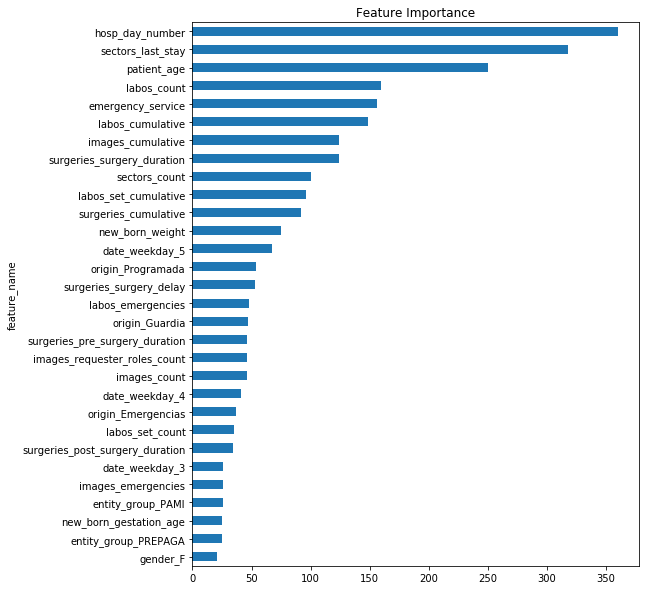

In [15]:
lgbm_date_features.plot_feature_importance()

In [16]:
lgbm_param_grid = {'max_depth': [3,7,10],
                  'learning_rate': [0.1,0.01,0.001,0.0001],
                  'num_iterations': [50,100,150,200,250]}

In [17]:
lgbm_date_features.optimize_hyperparams(params_dict=lgbm_param_grid,
                                         n_folds=3,n_iter=5,
                                         search_type='grid')

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  9.3min finished


{'mean_fit_time': array([ 3.39328837,  5.28193521,  6.87574546,  8.8530163 , 12.91750908,
         5.34240627,  7.56440727, 10.23546934, 12.66929142, 15.32942271,
         5.2385544 ,  7.5685904 , 12.07584174, 13.92740925, 17.46957397,
         3.67361164,  6.52896539,  7.90376806, 10.42144171, 13.71988694,
         5.34655857,  9.61369371, 13.17000993, 17.76035301, 22.51255035,
         5.61227107, 10.63432638, 15.73035971, 19.3312072 , 21.23051325,
         3.05093908,  5.97398067,  9.91272759, 10.09268824, 12.33730666,
         4.81837837,  8.55084427, 12.48575068, 16.54898604, 20.78725632,
         5.23375996,  9.11956429, 13.72224466, 18.17096074, 21.93780343,
         3.13675173,  5.41808303,  8.02495797, 10.07456605, 11.88668243,
         4.70961301,  8.95380418, 12.42385062, 15.78665082, 19.98035336,
         4.98922523,  9.12126009, 13.42999228, 17.84745137, 19.46418961]),
 'std_fit_time': array([0.01714522, 0.21134596, 0.10008099, 0.11775012, 0.38333068,
        0.57773113, 0

In [18]:
exp_results = lgbm_date_features.get_model_selection_results()

In [19]:
exp_results.to_csv('experiments/lgb_date_features_grid_search_results.csv')

In [20]:
best_params = lgbm_date_features.model_selection.best_params_
best_params

{'learning_rate': 0.1, 'max_depth': 7, 'num_iterations': 200}

In [22]:
lgbm_date_features.fit_best_classifier()

Training classifier


In [23]:
lgbm_date_features.get_performance_metrics()

training AUC ROC score:  0.8807785212875912
validation AUC ROC score:  0.862532939478183
relative overfitting:  0.020715289222465755


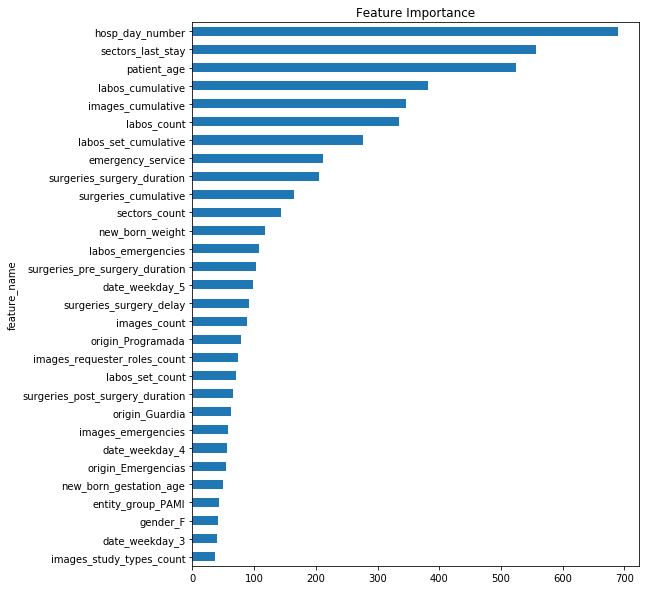

In [24]:
lgbm_date_features.plot_feature_importance(30)